## **VGG16: Image Modality for Humanitarian Task**

Se usa la arquitectura de redes neuronales convolucionales desarrollada por la Universidad de Oxford

In [1]:
import tensorflow as tf
import os

# Configurar para usar SOLO GPU 0 (la que está libre)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print("✅ TensorFlow version:", tf.__version__)
print("✅ GPU en uso:", tf.config.list_physical_devices('GPU'))

# Configurar memoria para mejor rendimiento
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("✅ GPU 0 configurada correctamente")

2025-11-25 22:41:44.434003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ TensorFlow version: 2.20.0
✅ GPU en uso: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU 0 configurada correctamente


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
from PIL import Image
import os

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### **Preprocesamiento de imágenes**
- Redimensionar y normalizar (224x224)
- Valores de los pixeles entre 0 y 1
- Normalizar los canales de color con respecto al dataset ImageNet

In [5]:
# Los datos ya fueron preprocesados y guardados como archivos .npy
# Falta cargar los datos
default_path = "/home/jacruz/crisis/data/preprocessed_images/"
df = pd.read_csv("/home/jacruz/crisis/data/crisis_images_dataset_humanitarian.csv")

image_names = df['image_name'].tolist()
labels = df['image_human'].tolist()

In [6]:
image_paths = [default_path + name + '.npy' for name in image_names]
image_paths[:5]

['/home/jacruz/crisis/data/preprocessed_images/917791044158185473_0.npy',
 '/home/jacruz/crisis/data/preprocessed_images/917791130590183424_0.npy',
 '/home/jacruz/crisis/data/preprocessed_images/917791291823591425_0.npy',
 '/home/jacruz/crisis/data/preprocessed_images/917791291823591425_1.npy',
 '/home/jacruz/crisis/data/preprocessed_images/917792092100988929_0.npy']

In [7]:
image_path = image_paths[0]
if not os.path.exists(image_path):
                print(f"Archivo no encontrado: {image_path}")

In [8]:
def load_images_from_paths(image_paths, target_size=(224, 224)):
    """
    Carga imágenes desde rutas de archivo
    """
    images = []
    valid_indices = []
    
    print(f"Cargando {len(image_paths)} imágenes desde rutas...")
    
    for i, npy_path in enumerate(image_paths):
        try:
            # Verificar si el archivo existe
            if not os.path.exists(npy_path):
                print(f"Archivo no encontrado: {npy_path}")
                continue
                
            # Cargar array numpy
            img_array = np.load(npy_path)
            
            images.append(img_array)
            valid_indices.append(i)
            
        except Exception as e:
            print(f"Error cargando imagen {npy_path}: {e}")
            print(f"Forma del array: {img_array.shape}" if 'img_array' in locals() else "No se pudo cargar el array.")
            continue
            
        # Mostrar progreso cada 1000 imágenes
        if (i + 1) % 1000 == 0:
            print(f"Procesadas {i + 1}/{len(image_paths)} imágenes")
    
    print(f"Imágenes cargadas exitosamente: {len(images)}/{len(image_paths)}")
    
    return np.array(images), valid_indices

In [9]:

def load_and_prepare_data():
    """
    Carga los arrays numpy preprocesados (.npy) y prepara para entrenamiento
    """
    # Cargar los arrays
    X_paths = np.array(image_paths)
    y_labels = np.array(labels)
    
    # Verificar formas
    print(f"Número de rutas de imágenes: {len(X_paths)}")
    print(f"Número de etiquetas: {len(y_labels)}")

    # Cargar imágenes desde las rutas
    X_images, valid_indices = load_images_from_paths(X_paths)

    # Filtrar etiquetas para mantener solo las correspondientes a imágenes cargadas exitosamente
    y_labels_filtered = y_labels[valid_indices]
    
    # Identificar todas las clases únicas
    unique_classes = np.unique(y_labels_filtered)
    num_classes = len(unique_classes)
    
    print(f"Clases disponibles: {list(unique_classes)}")
    print(f"Número de clases: {num_classes}")

    # Mapeo de texto a números
    class_mapping = {cls: i for i, cls in enumerate(unique_classes)}
    print(f"Mapping de clases: {class_mapping}")
    
    # Convertir etiquetas de texto a numéricas
    y_numeric = np.array([class_mapping[label] for label in y_labels_filtered])
    
    print(f"Distribución de etiquetas:")
    for cls, idx in class_mapping.items():
        count = np.sum(y_numeric == idx)
        percentage = (count / len(y_numeric)) * 100
        print(f"  {cls}: {count} ejemplos ({percentage:.1f}%)")

    # Se asegura de tener el formato correcto
    X_images = X_images.astype('float32')

    y_categorical = to_categorical(y_numeric, num_classes=num_classes)

    print(f"Rango de valores en X: min {X_images.min():.3f}, max {X_images.max():.3f}")

    print(f"Forma final de X: {X_images.shape}")
    print(f"Forma final de y: {y_categorical.shape}")
    return X_images, y_categorical, unique_classes, class_mapping

def split_data(X, y, test_size=0.3, val_size=0.5):
    """
    Divide los datos en train, validation y test y convierte a arrays numpy
    """
    X = np.array(X)
    y = np.array(y)

    print(f"Forma de X antes de split: {X.shape}")
    print(f"Forma de y antes de split: {y.shape}")

    # Primera división: train vs (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Segunda división: val vs test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=42, stratify=y_temp
    )

    print(f"Formas después del split:")
    print(f"Forma de X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Forma de X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"Forma de X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### **Arquitectura del modelo**
Se usa el modelo pre-entrenado VGG16 para aplicar transfer learning
- Se busca reutilizar los pesos
- Se reemplaza la última capa por _softmax_ 

In [10]:

def create_vgg16_model(num_classes, input_shape=(224, 224, 3)):
    """
    Crea el modelo VGG16 para clasificación multiclase
    según la descripción del paper
    """
    # Cargar VGG16 pre-entrenado en ImageNet (sin la capa final)
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Congelar las capas convolucionales (transfer learning)
    for layer in base_model.layers:
        layer.trainable = False
    
    # Añadir capas personalizadas según el paper
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)  # Capa fc2 mencionada en el paper
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)  # Dropout rate usado en el paper
    
    # Capa de salida
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Modelo final
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

### **Entrenamiento**
- Uso del Adam optimizer con initial learning rate de 10^-6
- Se reduce la tasa de aprendizaje en 0.1 si el accuracy deja de mejorar después de las 100 épocas
- El máximo de épocas es 1000, con early stopping

In [11]:
def setup_training(model):
    """
    Configura el optimizador y callbacks según el paper
    """
    # Optimizador Adam con learning rate muy bajo (1e-6) como en el paper
    optimizer = Adam(learning_rate=1e-6)
    
    # Callbacks
    callbacks = [
        # Early stopping con paciencia de 100 epochs (como en el paper)
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=100,
            restore_best_weights=True
        ),
        # ReduceLROnPlateau (mencionado en el paper)
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.1,
            patience=50,
            min_lr=1e-8
        ),
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'best_vgg16_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        )
    ]
    
    # Compilar modelo
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    return callbacks

### **Evaluación del modelo**

In [12]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_model(model, X_test, y_test, class_names):
    """
    Evaluación completa del modelo
    """
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, 
                              target_names=class_names,
                              digits=4))
    
    # Matriz de confusión
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Matriz de Confusión - Clasificación Multiclase')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true_classes, y_pred_classes, average=None
    )

    print("\nMétricas por clase:")
    print(f"{'Clase':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 60)
    for i, cls in enumerate(class_names):
        print(f"{cls:<15} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1[i]:<10.4f} {support[i]:<10}")
    
    # Métricas generales
    micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(
        y_true_classes, y_pred_classes, average='micro'
    )
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        y_true_classes, y_pred_classes, average='macro'
    )
    
    print(f"\nMétricas generales:")
    print(f"Micro-average F1: {micro_f1:.4f}")
    print(f"Macro-average F1: {macro_f1:.4f}")
    print(f"Micro-average Precision: {micro_precision:.4f}")
    print(f"Macro-average Precision: {macro_precision:.4f}")
    
    return y_pred_classes, y_true_classes

In [13]:
def plot_learning_curves(history):
    """
    Grafica las curvas de aprendizaje para accuracy y loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfico de accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Gráfico de loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Gráficos adicionales para precision y recall si existen
    if 'precision' in history.history:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Precision
        ax1.plot(history.history['precision'], label='Train Precision')
        ax1.plot(history.history['val_precision'], label='Validation Precision')
        ax1.set_title('Model Precision')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Precision')
        ax1.legend()
        ax1.grid(True)
        
        # Recall
        ax2.plot(history.history['recall'], label='Train Recall')
        ax2.plot(history.history['val_recall'], label='Validation Recall')
        ax2.set_title('Model Recall')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Recall')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

def plot_detailed_learning_curves(history):
    """
    Grafica curvas de aprendizaje más detalladas
    """
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, metric in enumerate(metrics):
        axes[i].plot(history.history[metric], label=f'Train {metric.title()}')
        if f'val_{metric}' in history.history:
            axes[i].plot(history.history[f'val_{metric}'], 
                        label=f'Validation {metric.title()}')
        
        axes[i].set_title(f'Model {metric.title()}')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric.title())
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

Cargando datos multiclase...
Número de rutas de imágenes: 18082
Número de etiquetas: 18082
Cargando 18082 imágenes desde rutas...
Procesadas 1000/18082 imágenes
Procesadas 2000/18082 imágenes
Procesadas 3000/18082 imágenes
Procesadas 4000/18082 imágenes
Procesadas 5000/18082 imágenes
Procesadas 6000/18082 imágenes
Procesadas 7000/18082 imágenes
Procesadas 8000/18082 imágenes
Procesadas 9000/18082 imágenes
Procesadas 10000/18082 imágenes
Procesadas 11000/18082 imágenes
Procesadas 12000/18082 imágenes
Procesadas 13000/18082 imágenes
Procesadas 14000/18082 imágenes
Procesadas 15000/18082 imágenes
Procesadas 16000/18082 imágenes
Procesadas 17000/18082 imágenes
Procesadas 18000/18082 imágenes
Imágenes cargadas exitosamente: 18082/18082
Clases disponibles: [np.str_('affected_individuals'), np.str_('infrastructure_and_utility_damage'), np.str_('injured_or_dead_people'), np.str_('missing_or_found_people'), np.str_('not_humanitarian'), np.str_('other_relevant_information'), np.str_('rescue_volu

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │       513,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         8,00

 Total params: 15,239,696 (58.13 MB)

 Trainable params: 523,008 (2.00 MB)

 Non-trainable params: 14,716,688 (56.14 MB)

Iniciando entrenamiento multiclase...


2025-11-25 10:06:49.592047: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 7620931584 exceeds 10% of free system memory.
2025-11-25 10:06:54.628498: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 7620931584 exceeds 10% of free system memory.


Epoch 1/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1446 - loss: 2.4015 - precision: 0.2077 - recall: 0.0279

396/396 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.1568 - loss: 2.3380 - precision: 0.2304 - recall: 0.0288 - val_accuracy: 0.1718 - val_loss: 2.1311 - val_precision: 0.4091 - val_recall: 0.0066 - learning_rate: 1.0000e-06
Epoch 2/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2069 - loss: 2.1770 - precision: 0.3066 - recall: 0.0346

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.2233 - loss: 2.1327 - precision: 0.3488 - recall: 0.0404 - val_accuracy: 0.2555 - val_loss: 2.0535 - val_precision: 0.3822 - val_recall: 0.0490 - learning_rate: 1.0000e-06
Epoch 3/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2903 - loss: 2.0118 - precision: 0.4592 - recall: 0.0568

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.3029 - loss: 1.9757 - precision: 0.4907 - recall: 0.0628 - val_accuracy: 0.3333 - val_loss: 1.9164 - val_precision: 0.5036 - val_recall: 0.0782 - learning_rate: 1.0000e-06
Epoch 4/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3422 - loss: 1.8838 - precision: 0.5994 - recall: 0.0881

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.3575 - loss: 1.8599 - precision: 0.5879 - recall: 0.0943 - val_accuracy: 0.3964 - val_loss: 1.8153 - val_precision: 0.5731 - val_recall: 0.1069 - learning_rate: 1.0000e-06
Epoch 5/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3975 - loss: 1.7885 - precision: 0.6431 - recall: 0.1165

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.4064 - loss: 1.7731 - precision: 0.6589 - recall: 0.1289 - val_accuracy: 0.4296 - val_loss: 1.7422 - val_precision: 0.6314 - val_recall: 0.1409 - learning_rate: 1.0000e-06
Epoch 6/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4279 - loss: 1.7382 - precision: 0.6721 - recall: 0.1591

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.4468 - loss: 1.7038 - precision: 0.6878 - recall: 0.1692 - val_accuracy: 0.4653 - val_loss: 1.6788 - val_precision: 0.6760 - val_recall: 0.1785 - learning_rate: 1.0000e-06
Epoch 7/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4693 - loss: 1.6555 - precision: 0.7180 - recall: 0.1975

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.4724 - loss: 1.6526 - precision: 0.7058 - recall: 0.2019 - val_accuracy: 0.4904 - val_loss: 1.6264 - val_precision: 0.6945 - val_recall: 0.2087 - learning_rate: 1.0000e-06
Epoch 8/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4890 - loss: 1.6291 - precision: 0.7178 - recall: 0.2239

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.4936 - loss: 1.6137 - precision: 0.7144 - recall: 0.2358 - val_accuracy: 0.5173 - val_loss: 1.5806 - val_precision: 0.7091 - val_recall: 0.2544 - learning_rate: 1.0000e-06
Epoch 9/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5107 - loss: 1.5716 - precision: 0.7290 - recall: 0.2599

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5153 - loss: 1.5756 - precision: 0.7238 - recall: 0.2631 - val_accuracy: 0.5291 - val_loss: 1.5500 - val_precision: 0.7185 - val_recall: 0.2795 - learning_rate: 1.0000e-06
Epoch 10/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5307 - loss: 1.5500 - precision: 0.7305 - recall: 0.2843

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5280 - loss: 1.5456 - precision: 0.7299 - recall: 0.2838 - val_accuracy: 0.5391 - val_loss: 1.5263 - val_precision: 0.7255 - val_recall: 0.3001 - learning_rate: 1.0000e-06
Epoch 11/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5405 - loss: 1.5384 - precision: 0.7232 - recall: 0.2936

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5418 - loss: 1.5189 - precision: 0.7317 - recall: 0.3036 - val_accuracy: 0.5446 - val_loss: 1.4974 - val_precision: 0.7361 - val_recall: 0.3167 - learning_rate: 1.0000e-06
Epoch 12/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5555 - loss: 1.4973 - precision: 0.7426 - recall: 0.3238

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.5540 - loss: 1.4881 - precision: 0.7434 - recall: 0.3235 - val_accuracy: 0.5524 - val_loss: 1.4832 - val_precision: 0.7408 - val_recall: 0.3267 - learning_rate: 1.0000e-06
Epoch 13/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5574 - loss: 1.4903 - precision: 0.7442 - recall: 0.3269

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5594 - loss: 1.4726 - precision: 0.7444 - recall: 0.3336 - val_accuracy: 0.5590 - val_loss: 1.4575 - val_precision: 0.7484 - val_recall: 0.3411 - learning_rate: 1.0000e-06
Epoch 14/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5662 - loss: 1.4607 - precision: 0.7482 - recall: 0.3425

396/396 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.5662 - loss: 1.4523 - precision: 0.7477 - recall: 0.3434 - val_accuracy: 0.5660 - val_loss: 1.4426 - val_precision: 0.7471 - val_recall: 0.3540 - learning_rate: 1.0000e-06
Epoch 15/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5723 - loss: 1.4378 - precision: 0.7590 - recall: 0.3605

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5740 - loss: 1.4342 - precision: 0.7524 - recall: 0.3596 - val_accuracy: 0.5712 - val_loss: 1.4233 - val_precision: 0.7556 - val_recall: 0.3636 - learning_rate: 1.0000e-06
Epoch 16/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5809 - loss: 1.4222 - precision: 0.7536 - recall: 0.3603

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5801 - loss: 1.4182 - precision: 0.7529 - recall: 0.3664 - val_accuracy: 0.5719 - val_loss: 1.4171 - val_precision: 0.7537 - val_recall: 0.3713 - learning_rate: 1.0000e-06
Epoch 17/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5823 - loss: 1.4115 - precision: 0.7521 - recall: 0.3681

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5859 - loss: 1.4022 - precision: 0.7542 - recall: 0.3769 - val_accuracy: 0.5859 - val_loss: 1.3932 - val_precision: 0.7551 - val_recall: 0.3809 - learning_rate: 1.0000e-06
Epoch 18/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5879 - loss: 1.4047 - precision: 0.7538 - recall: 0.3852

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5926 - loss: 1.3919 - precision: 0.7571 - recall: 0.3856 - val_accuracy: 0.5889 - val_loss: 1.3906 - val_precision: 0.7547 - val_recall: 0.3868 - learning_rate: 1.0000e-06
Epoch 19/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5931 - loss: 1.3917 - precision: 0.7431 - recall: 0.3891

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5940 - loss: 1.3833 - precision: 0.7507 - recall: 0.3912 - val_accuracy: 0.5933 - val_loss: 1.3754 - val_precision: 0.7612 - val_recall: 0.3938 - learning_rate: 1.0000e-06
Epoch 20/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5911 - loss: 1.3795 - precision: 0.7556 - recall: 0.3923

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5956 - loss: 1.3657 - precision: 0.7609 - recall: 0.3983 - val_accuracy: 0.5959 - val_loss: 1.3604 - val_precision: 0.7579 - val_recall: 0.3982 - learning_rate: 1.0000e-06
Epoch 21/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5999 - loss: 1.3533 - precision: 0.7672 - recall: 0.4013

396/396 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.6012 - loss: 1.3545 - precision: 0.7594 - recall: 0.4034 - val_accuracy: 0.5985 - val_loss: 1.3507 - val_precision: 0.7598 - val_recall: 0.4012 - learning_rate: 1.0000e-06
Epoch 22/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6054 - loss: 1.3433 - precision: 0.7562 - recall: 0.4005

396/396 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.6069 - loss: 1.3405 - precision: 0.7587 - recall: 0.4039 - val_accuracy: 0.5988 - val_loss: 1.3385 - val_precision: 0.7612 - val_recall: 0.4056 - learning_rate: 1.0000e-06
Epoch 23/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6082 - loss: 1.3440 - precision: 0.7610 - recall: 0.4133

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6109 - loss: 1.3331 - precision: 0.7627 - recall: 0.4131 - val_accuracy: 0.6018 - val_loss: 1.3258 - val_precision: 0.7621 - val_recall: 0.4122 - learning_rate: 1.0000e-06
Epoch 24/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6079 - loss: 1.3337 - precision: 0.7574 - recall: 0.4077

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6095 - loss: 1.3191 - precision: 0.7584 - recall: 0.4130 - val_accuracy: 0.6051 - val_loss: 1.3126 - val_precision: 0.7641 - val_recall: 0.4156 - learning_rate: 1.0000e-06
Epoch 25/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6137 - loss: 1.3015 - precision: 0.7659 - recall: 0.4145

396/396 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.6145 - loss: 1.3050 - precision: 0.7654 - recall: 0.4176 - val_accuracy: 0.6058 - val_loss: 1.3049 - val_precision: 0.7649 - val_recall: 0.4200 - learning_rate: 1.0000e-06
Epoch 26/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6231 - loss: 1.2818 - precision: 0.7696 - recall: 0.4271

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6197 - loss: 1.2946 - precision: 0.7670 - recall: 0.4242 - val_accuracy: 0.6073 - val_loss: 1.2976 - val_precision: 0.7637 - val_recall: 0.4266 - learning_rate: 1.0000e-06
Epoch 27/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6211 - loss: 1.2971 - precision: 0.7662 - recall: 0.4232

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6228 - loss: 1.2901 - precision: 0.7684 - recall: 0.4270 - val_accuracy: 0.6077 - val_loss: 1.3029 - val_precision: 0.7584 - val_recall: 0.4248 - learning_rate: 1.0000e-06
Epoch 28/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6168 - loss: 1.3052 - precision: 0.7518 - recall: 0.4234

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6257 - loss: 1.2812 - precision: 0.7634 - recall: 0.4328 - val_accuracy: 0.6143 - val_loss: 1.2802 - val_precision: 0.7672 - val_recall: 0.4362 - learning_rate: 1.0000e-06
Epoch 29/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6293 - loss: 1.2690 - precision: 0.7748 - recall: 0.4333

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6287 - loss: 1.2684 - precision: 0.7729 - recall: 0.4364 - val_accuracy: 0.6165 - val_loss: 1.2651 - val_precision: 0.7695 - val_recall: 0.4406 - learning_rate: 1.0000e-06
Epoch 30/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6293 - loss: 1.2575 - precision: 0.7675 - recall: 0.4391 - val_accuracy: 0.6150 - val_loss: 1.2728 - val_precision: 0.7654 - val_recall: 0.4392 - learning_rate: 1.0000e-06
Epoch 31/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6336 - loss: 1.2377 - precision: 0.7843 - recall: 0.4459

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6298 - loss: 1.2533 - precision: 0.7769 - recall: 0.4442 - val_accuracy: 0.6173 - val_loss: 1.2615 - val_precision: 0.7668 - val_recall: 0.4425 - learning_rate: 1.0000e-06
Epoch 32/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6380 - loss: 1.2393 - precision: 0.7701 - recall: 0.4453

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6343 - loss: 1.2488 - precision: 0.7709 - recall: 0.4462 - val_accuracy: 0.6213 - val_loss: 1.2494 - val_precision: 0.7644 - val_recall: 0.4451 - learning_rate: 1.0000e-06
Epoch 33/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6354 - loss: 1.2370 - precision: 0.7714 - recall: 0.4464 - val_accuracy: 0.6191 - val_loss: 1.2455 - val_precision: 0.7659 - val_recall: 0.4476 - learning_rate: 1.0000e-06
Epoch 34/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6340 - loss: 1.2371 - precision: 0.7802 - recall: 0.4477

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6359 - loss: 1.2292 - precision: 0.7773 - recall: 0.4534 - val_accuracy: 0.6228 - val_loss: 1.2356 - val_precision: 0.7668 - val_recall: 0.4510 - learning_rate: 1.0000e-06
Epoch 35/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6303 - loss: 1.2512 - precision: 0.7648 - recall: 0.4474

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6426 - loss: 1.2193 - precision: 0.7752 - recall: 0.4553 - val_accuracy: 0.6246 - val_loss: 1.2285 - val_precision: 0.7701 - val_recall: 0.4521 - learning_rate: 1.0000e-06
Epoch 36/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6423 - loss: 1.2105 - precision: 0.7784 - recall: 0.4601 - val_accuracy: 0.6239 - val_loss: 1.2252 - val_precision: 0.7690 - val_recall: 0.4543 - learning_rate: 1.0000e-06
Epoch 37/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6449 - loss: 1.2040 - precision: 0.7821 - recall: 0.4648 - val_accuracy: 0.6243 - val_loss: 1.2243 - val_precision: 0.7684 - val_recall: 0.4550 - learning_rate: 1.0000e-06
Epoch 38/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6427 - loss: 1.2061 - precision: 0.7785 - recall: 0.4600

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6448 - loss: 1.1952 - precision: 0.7776 - recall: 0.4649 - val_accuracy: 0.6294 - val_loss: 1.2098 - val_precision: 0.7700 - val_recall: 0.4605 - learning_rate: 1.0000e-06
Epoch 39/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6479 - loss: 1.1923 - precision: 0.7801 - recall: 0.4671

396/396 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.6479 - loss: 1.1868 - precision: 0.7821 - recall: 0.4673 - val_accuracy: 0.6302 - val_loss: 1.2051 - val_precision: 0.7696 - val_recall: 0.4631 - learning_rate: 1.0000e-06
Epoch 40/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6493 - loss: 1.1892 - precision: 0.7811 - recall: 0.4663

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6493 - loss: 1.1819 - precision: 0.7810 - recall: 0.4688 - val_accuracy: 0.6331 - val_loss: 1.1931 - val_precision: 0.7706 - val_recall: 0.4657 - learning_rate: 1.0000e-06
Epoch 41/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6483 - loss: 1.1803 - precision: 0.7803 - recall: 0.4715 - val_accuracy: 0.6302 - val_loss: 1.1928 - val_precision: 0.7728 - val_recall: 0.4664 - learning_rate: 1.0000e-06
Epoch 42/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6537 - loss: 1.1680 - precision: 0.7813 - recall: 0.4752 - val_accuracy: 0.6309 - val_loss: 1.1951 - val_precision: 0.7715 - val_recall: 0.4657 - learning_rate: 1.0000e-06
Epoch 43/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6523 - loss: 1.1667 - precision: 0.7792 - recall: 0.4678

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6551 - loss: 1.1565 - precision: 0.7823 - recall: 0.4765 - val_accuracy: 0.6383 - val_loss: 1.1776 - val_precision: 0.7715 - val_recall: 0.4705 - learning_rate: 1.0000e-06
Epoch 44/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6581 - loss: 1.1525 - precision: 0.7827 - recall: 0.4782 - val_accuracy: 0.6361 - val_loss: 1.1818 - val_precision: 0.7701 - val_recall: 0.4694 - learning_rate: 1.0000e-06
Epoch 45/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6576 - loss: 1.1431 - precision: 0.7868 - recall: 0.4853 - val_accuracy: 0.6375 - val_loss: 1.1726 - val_precision: 0.7725 - val_recall: 0.4694 - learning_rate: 1.0000e-06
Epoch 46/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6509 - loss: 1.1505 - precision: 0.7750 - recall: 0.4861

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6556 - loss: 1.1431 - precision: 0.7856 - recall: 0.4865 - val_accuracy: 0.6416 - val_loss: 1.1655 - val_precision: 0.7725 - val_recall: 0.4720 - learning_rate: 1.0000e-06
Epoch 47/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6545 - loss: 1.1633 - precision: 0.7811 - recall: 0.4788

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6629 - loss: 1.1335 - precision: 0.7859 - recall: 0.4883 - val_accuracy: 0.6431 - val_loss: 1.1591 - val_precision: 0.7703 - val_recall: 0.4797 - learning_rate: 1.0000e-06
Epoch 48/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6619 - loss: 1.1323 - precision: 0.7877 - recall: 0.4895 - val_accuracy: 0.6416 - val_loss: 1.1581 - val_precision: 0.7695 - val_recall: 0.4801 - learning_rate: 1.0000e-06
Epoch 49/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6617 - loss: 1.1434 - precision: 0.7783 - recall: 0.4882

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6626 - loss: 1.1248 - precision: 0.7834 - recall: 0.4895 - val_accuracy: 0.6442 - val_loss: 1.1493 - val_precision: 0.7771 - val_recall: 0.4782 - learning_rate: 1.0000e-06
Epoch 50/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6638 - loss: 1.1161 - precision: 0.7866 - recall: 0.4962 - val_accuracy: 0.6409 - val_loss: 1.1539 - val_precision: 0.7718 - val_recall: 0.4801 - learning_rate: 1.0000e-06
Epoch 51/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6749 - loss: 1.1020 - precision: 0.8018 - recall: 0.5056

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.6680 - loss: 1.1115 - precision: 0.7901 - recall: 0.4974 - val_accuracy: 0.6468 - val_loss: 1.1400 - val_precision: 0.7745 - val_recall: 0.4889 - learning_rate: 1.0000e-06
Epoch 52/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6631 - loss: 1.1045 - precision: 0.7920 - recall: 0.4994 - val_accuracy: 0.6464 - val_loss: 1.1367 - val_precision: 0.7744 - val_recall: 0.4886 - learning_rate: 1.0000e-06
Epoch 53/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6717 - loss: 1.1004 - precision: 0.7875 - recall: 0.4991 - val_accuracy: 0.6468 - val_loss: 1.1325 - val_precision: 0.7730 - val_recall: 0.4897 - learning_rate: 1.0000e-06
Epoch 54/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6665 - loss: 1.0941 - precision: 0.7899 - recall: 0.4988

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.6677 - loss: 1.0959 - precision: 0.7894 - recall: 0.5040 - val_accuracy: 0.6504 - val_loss: 1.1198 - val_precision: 0.7750 - val_recall: 0.4915 - learning_rate: 1.0000e-06
Epoch 55/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6706 - loss: 1.0879 - precision: 0.7880 - recall: 0.5030 - val_accuracy: 0.6490 - val_loss: 1.1238 - val_precision: 0.7716 - val_recall: 0.4882 - learning_rate: 1.0000e-06
Epoch 56/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6746 - loss: 1.0738 - precision: 0.7925 - recall: 0.5119

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6740 - loss: 1.0793 - precision: 0.7900 - recall: 0.5090 - val_accuracy: 0.6519 - val_loss: 1.1068 - val_precision: 0.7764 - val_recall: 0.4941 - learning_rate: 1.0000e-06
Epoch 57/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6669 - loss: 1.0811 - precision: 0.7930 - recall: 0.5086

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6702 - loss: 1.0729 - precision: 0.7921 - recall: 0.5132 - val_accuracy: 0.6534 - val_loss: 1.1095 - val_precision: 0.7722 - val_recall: 0.4937 - learning_rate: 1.0000e-06
Epoch 58/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6763 - loss: 1.0704 - precision: 0.7921 - recall: 0.5127 - val_accuracy: 0.6508 - val_loss: 1.1053 - val_precision: 0.7739 - val_recall: 0.4959 - learning_rate: 1.0000e-06
Epoch 59/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6840 - loss: 1.0445 - precision: 0.7979 - recall: 0.5201

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6760 - loss: 1.0616 - precision: 0.7903 - recall: 0.5139 - val_accuracy: 0.6552 - val_loss: 1.0989 - val_precision: 0.7742 - val_recall: 0.5007 - learning_rate: 1.0000e-06
Epoch 60/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6814 - loss: 1.0556 - precision: 0.7934 - recall: 0.5165 - val_accuracy: 0.6552 - val_loss: 1.0943 - val_precision: 0.7760 - val_recall: 0.5033 - learning_rate: 1.0000e-06
Epoch 61/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6804 - loss: 1.0458 - precision: 0.8005 - recall: 0.5209

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6783 - loss: 1.0514 - precision: 0.7928 - recall: 0.5171 - val_accuracy: 0.6560 - val_loss: 1.0916 - val_precision: 0.7746 - val_recall: 0.5070 - learning_rate: 1.0000e-06
Epoch 62/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6790 - loss: 1.0448 - precision: 0.7882 - recall: 0.5271

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6803 - loss: 1.0478 - precision: 0.7873 - recall: 0.5222 - val_accuracy: 0.6567 - val_loss: 1.0850 - val_precision: 0.7753 - val_recall: 0.5088 - learning_rate: 1.0000e-06
Epoch 63/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6807 - loss: 1.0426 - precision: 0.7906 - recall: 0.5234 - val_accuracy: 0.6567 - val_loss: 1.0810 - val_precision: 0.7747 - val_recall: 0.5085 - learning_rate: 1.0000e-06
Epoch 64/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6728 - loss: 1.0578 - precision: 0.7861 - recall: 0.5168

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6818 - loss: 1.0372 - precision: 0.7930 - recall: 0.5218 - val_accuracy: 0.6571 - val_loss: 1.0835 - val_precision: 0.7743 - val_recall: 0.5085 - learning_rate: 1.0000e-06
Epoch 65/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6877 - loss: 1.0130 - precision: 0.7947 - recall: 0.5358

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6808 - loss: 1.0352 - precision: 0.7869 - recall: 0.5236 - val_accuracy: 0.6589 - val_loss: 1.0736 - val_precision: 0.7768 - val_recall: 0.5133 - learning_rate: 1.0000e-06
Epoch 66/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6785 - loss: 1.0337 - precision: 0.7866 - recall: 0.5253

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6795 - loss: 1.0329 - precision: 0.7888 - recall: 0.5241 - val_accuracy: 0.6615 - val_loss: 1.0658 - val_precision: 0.7780 - val_recall: 0.5181 - learning_rate: 1.0000e-06
Epoch 67/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6771 - loss: 1.0361 - precision: 0.7844 - recall: 0.5188

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6848 - loss: 1.0223 - precision: 0.7913 - recall: 0.5252 - val_accuracy: 0.6622 - val_loss: 1.0636 - val_precision: 0.7770 - val_recall: 0.5192 - learning_rate: 1.0000e-06
Epoch 68/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.6869 - loss: 1.0201 - precision: 0.7946 - recall: 0.5294 - val_accuracy: 0.6622 - val_loss: 1.0618 - val_precision: 0.7764 - val_recall: 0.5184 - learning_rate: 1.0000e-06
Epoch 69/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6879 - loss: 1.0099 - precision: 0.7951 - recall: 0.5336 - val_accuracy: 0.6611 - val_loss: 1.0616 - val_precision: 0.7768 - val_recall: 0.5184 - learning_rate: 1.0000e-06
Epoch 70/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6903 - loss: 1.0096 - precision: 0.7919 - recall: 0.5301

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6915 - loss: 1.0072 - precision: 0.7947 - recall: 0.5375 - val_accuracy: 0.6633 - val_loss: 1.0581 - val_precision: 0.7778 - val_recall: 0.5214 - learning_rate: 1.0000e-06
Epoch 71/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6863 - loss: 1.0000 - precision: 0.7993 - recall: 0.5404

396/396 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.6842 - loss: 1.0029 - precision: 0.7945 - recall: 0.5364 - val_accuracy: 0.6637 - val_loss: 1.0489 - val_precision: 0.7763 - val_recall: 0.5258 - learning_rate: 1.0000e-06
Epoch 72/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6908 - loss: 0.9942 - precision: 0.7940 - recall: 0.5364

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6874 - loss: 1.0033 - precision: 0.7911 - recall: 0.5375 - val_accuracy: 0.6645 - val_loss: 1.0475 - val_precision: 0.7769 - val_recall: 0.5251 - learning_rate: 1.0000e-06
Epoch 73/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6849 - loss: 1.0027 - precision: 0.7916 - recall: 0.5265

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6884 - loss: 0.9986 - precision: 0.7951 - recall: 0.5358 - val_accuracy: 0.6652 - val_loss: 1.0429 - val_precision: 0.7778 - val_recall: 0.5265 - learning_rate: 1.0000e-06
Epoch 74/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6919 - loss: 0.9899 - precision: 0.7962 - recall: 0.5359

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6930 - loss: 0.9831 - precision: 0.7981 - recall: 0.5428 - val_accuracy: 0.6681 - val_loss: 1.0332 - val_precision: 0.7794 - val_recall: 0.5354 - learning_rate: 1.0000e-06
Epoch 75/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6898 - loss: 0.9852 - precision: 0.7947 - recall: 0.5419 - val_accuracy: 0.6663 - val_loss: 1.0404 - val_precision: 0.7788 - val_recall: 0.5310 - learning_rate: 1.0000e-06
Epoch 76/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6819 - loss: 0.9872 - precision: 0.7919 - recall: 0.5395

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6896 - loss: 0.9803 - precision: 0.7978 - recall: 0.5432 - val_accuracy: 0.6696 - val_loss: 1.0320 - val_precision: 0.7777 - val_recall: 0.5328 - learning_rate: 1.0000e-06
Epoch 77/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6898 - loss: 0.9859 - precision: 0.7930 - recall: 0.5423

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6921 - loss: 0.9791 - precision: 0.7962 - recall: 0.5451 - val_accuracy: 0.6700 - val_loss: 1.0270 - val_precision: 0.7768 - val_recall: 0.5324 - learning_rate: 1.0000e-06
Epoch 78/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7022 - loss: 0.9625 - precision: 0.7980 - recall: 0.5487

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.6933 - loss: 0.9742 - precision: 0.7951 - recall: 0.5467 - val_accuracy: 0.6715 - val_loss: 1.0182 - val_precision: 0.7777 - val_recall: 0.5365 - learning_rate: 1.0000e-06
Epoch 79/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6899 - loss: 0.9669 - precision: 0.8001 - recall: 0.5488

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6943 - loss: 0.9678 - precision: 0.7990 - recall: 0.5497 - val_accuracy: 0.6718 - val_loss: 1.0138 - val_precision: 0.7774 - val_recall: 0.5395 - learning_rate: 1.0000e-06
Epoch 80/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6947 - loss: 0.9646 - precision: 0.7993 - recall: 0.5527 - val_accuracy: 0.6704 - val_loss: 1.0219 - val_precision: 0.7771 - val_recall: 0.5347 - learning_rate: 1.0000e-06
Epoch 81/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6945 - loss: 0.9605 - precision: 0.7975 - recall: 0.5565

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6946 - loss: 0.9594 - precision: 0.7980 - recall: 0.5554 - val_accuracy: 0.6733 - val_loss: 1.0114 - val_precision: 0.7767 - val_recall: 0.5398 - learning_rate: 1.0000e-06
Epoch 82/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7009 - loss: 0.9621 - precision: 0.8024 - recall: 0.5569

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6984 - loss: 0.9556 - precision: 0.7998 - recall: 0.5563 - val_accuracy: 0.6744 - val_loss: 1.0065 - val_precision: 0.7780 - val_recall: 0.5439 - learning_rate: 1.0000e-06
Epoch 83/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6990 - loss: 0.9484 - precision: 0.7991 - recall: 0.5542 - val_accuracy: 0.6744 - val_loss: 1.0029 - val_precision: 0.7776 - val_recall: 0.5428 - learning_rate: 1.0000e-06
Epoch 84/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6986 - loss: 0.9460 - precision: 0.7983 - recall: 0.5565 - val_accuracy: 0.6733 - val_loss: 0.9990 - val_precision: 0.7773 - val_recall: 0.5468 - learning_rate: 1.0000e-06
Epoch 85/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7038 - loss: 0.9398 - precision: 0.7992 - recall: 0.5614 - val_accuracy: 0.6740 - val_loss: 0.9960 - val_precision: 0.7784 - val_recall: 0.5465 - learning_rate: 1.0000e-06
Epoch 86/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7029 - loss: 0.9385 - precision: 0.8039 - recall: 0.5608 - val_accuracy: 0.6748 - val_loss: 0.9933 - val_precision: 0.7780 - val_recall: 0.5479 - learning_rate: 1.0000e-06
Epoch 87/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7014 - loss: 0.9351 - precision: 0.7968 - recall: 0.5607 - val_accuracy: 0.6744 - val_loss: 0.9959 - val_precision: 0.7770 - val_recall: 0.5461 - learning_rate: 1.0000e-06
Epoch 88/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7009 - loss: 0.9288 - precision: 0.8003 - recall: 0.5644 - val_accuracy: 0.6744 - val_loss: 0.9899 - val_precision: 0.7789 - val_recall: 0.5494 - learning_rate: 1.0000e-06
Epoch 89/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7010 - loss: 0.9306 - precision: 0.7972 - recall: 0.5636 - val_accuracy: 0.6740 - val_loss: 0.9883 - val_precision: 0.7775 - val_recall: 0.5501 - learning_rate: 1.0000e-06
Epoch 90/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7079 - loss: 0.9197 - precision: 0.7969 - recall: 0.5679 - val_accuracy: 0.6803 - val_loss: 0.9829 - val_precision: 0.7755 - val_recall: 0.5527 - learning_rate: 1.0000e-06
Epoch 91/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7053 - loss: 0.9204 - precision: 0.7965 - recall: 0.5679 - val_accuracy: 0.6785 - val_loss: 0.9818 - val_precision: 0.7752 - val_recall: 0.5520 - learning_rate: 1.0000e-06
Epoch 92/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7037 - loss: 0.9166 - precision: 0.7979 - recall: 0.5664 - val_accuracy: 0.6774 - val_loss: 0.9786 - val_precision: 0.7768 - val_recall: 0.5531 - learning_rate: 1.0000e-06
Epoch 93/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6989 - loss: 0.9296 - precision: 0.7925 - recall: 0.5683

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7041 - loss: 0.9129 - precision: 0.7987 - recall: 0.5726 - val_accuracy: 0.6807 - val_loss: 0.9721 - val_precision: 0.7771 - val_recall: 0.5568 - learning_rate: 1.0000e-06
Epoch 94/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7098 - loss: 0.9107 - precision: 0.7972 - recall: 0.5753

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.7076 - loss: 0.9043 - precision: 0.8030 - recall: 0.5734 - val_accuracy: 0.6810 - val_loss: 0.9720 - val_precision: 0.7737 - val_recall: 0.5560 - learning_rate: 1.0000e-06
Epoch 95/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7052 - loss: 0.9037 - precision: 0.8006 - recall: 0.5751 - val_accuracy: 0.6799 - val_loss: 0.9660 - val_precision: 0.7737 - val_recall: 0.5597 - learning_rate: 1.0000e-06
Epoch 96/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7083 - loss: 0.9002 - precision: 0.8004 - recall: 0.5772 - val_accuracy: 0.6807 - val_loss: 0.9679 - val_precision: 0.7748 - val_recall: 0.5568 - learning_rate: 1.0000e-06
Epoch 97/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7134 - loss: 0.8903 - precision: 0.8065 - recall: 0.5876

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7081 - loss: 0.8996 - precision: 0.7993 - recall: 0.5810 - val_accuracy: 0.6825 - val_loss: 0.9611 - val_precision: 0.7733 - val_recall: 0.5623 - learning_rate: 1.0000e-06
Epoch 98/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7085 - loss: 0.8960 - precision: 0.7979 - recall: 0.5788 - val_accuracy: 0.6814 - val_loss: 0.9612 - val_precision: 0.7745 - val_recall: 0.5597 - learning_rate: 1.0000e-06
Epoch 99/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7123 - loss: 0.8906 - precision: 0.8017 - recall: 0.5817 - val_accuracy: 0.6814 - val_loss: 0.9583 - val_precision: 0.7738 - val_recall: 0.5601 - learning_rate: 1.0000e-06
Epoch 100/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7098 - loss: 0.8857 - precision: 0.7973 - recall: 0.5823 - val_accuracy: 0.6818 - val_loss: 0.9546 - val_precision: 0.7736 - val_recall: 0.5631 - learning_rate: 1.0000e-06
Evaluando en test set...

=== RESULTADOS FIN

/home/jacruz/.conda/envs/crisis-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jacruz/.conda/envs/crisis-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jacruz/.conda/envs/crisis-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

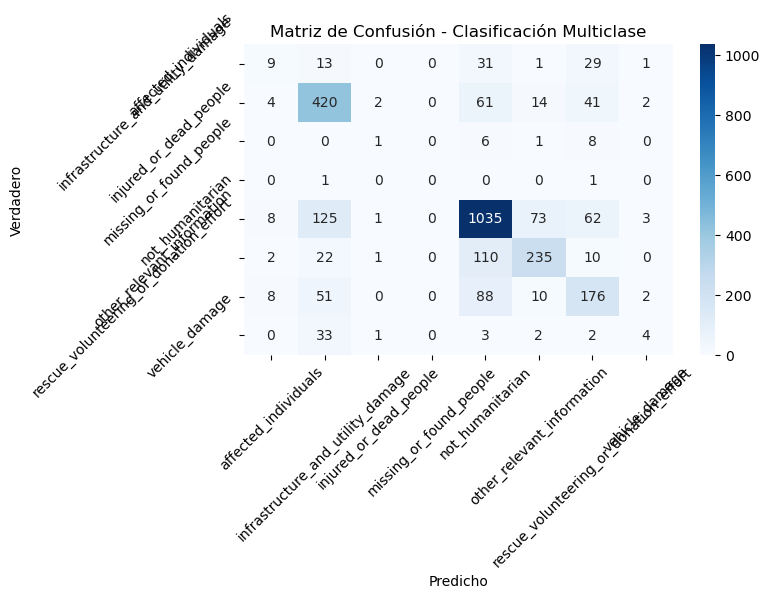


Métricas por clase:
Clase           Precision  Recall     F1-Score   Support   
------------------------------------------------------------
affected_individuals 0.2903     0.1071     0.1565     84        
infrastructure_and_utility_damage 0.6316     0.7721     0.6948     544       
injured_or_dead_people 0.1667     0.0625     0.0909     16        
missing_or_found_people 0.0000     0.0000     0.0000     2         
not_humanitarian 0.7759     0.7919     0.7838     1307      
other_relevant_information 0.6994     0.6184     0.6564     380       
rescue_volunteering_or_donation_effort 0.5350     0.5254     0.5301     335       
vehicle_damage  0.3333     0.0889     0.1404     45        


/home/jacruz/.conda/envs/crisis-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jacruz/.conda/envs/crisis-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Métricas generales:
Micro-average F1: 0.6930
Macro-average F1: 0.3816
Micro-average Precision: 0.6930
Macro-average Precision: 0.4290
Modelo y mapeo de clases guardados


In [ ]:
def main_multiclass():
    # 1. Cargar y preparar datos MULTICLASE
    print("Cargando datos multiclase...")
    X, y, class_names, class_mapping = load_and_prepare_data()
    
    print(f"Número de clases: {len(class_names)}")
    print(f"Clases: {list(class_names)}")
    
    # 2. Dividir datos
    print("Dividiendo datos...")
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    
    print(f"Train: {X_train.shape[0]} samples")
    print(f"Validation: {X_val.shape[0]} samples") 
    print(f"Test: {X_test.shape[0]} samples")
    
    # 3. Crear modelo MULTICLASE
    print("Creando modelo VGG16 para clasificación multiclase...")
    model = create_vgg16_model(num_classes=len(class_names))
    
    # Mostrar resumen
    model.summary()
    
    # 4. Configurar entrenamiento MULTICLASE
    callbacks = setup_training(model)
    
    # 5. Entrenar modelo
    print("Iniciando entrenamiento multiclase...")
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=100,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    # 6. Evaluar en test
    print("Evaluando en test set...")
    test_results = model.evaluate(X_test, y_test, verbose=0)
    test_loss, test_accuracy = test_results[0], test_results[1]
    
    print("\n=== RESULTADOS FINALES MULTICLASE ===")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    if len(test_results) > 2:
        print("\nOtras métricas:")
        for i in range(2, len(test_results)):
            print(f"Métrica {i-1}: {test_results[i]:.4f}")
    
    # Evaluación detallada multiclase
    evaluate_model(model, X_test, y_test, class_names)
    
    return model, history, (test_loss, test_accuracy), class_names

# Ejecutar entrenamiento multiclase
if __name__ == "__main__":
    model, history, results, class_names = main_multiclass()
    
    # Guardar el modelo y el mapeo de clases
    model.save('vgg16_multiclass.keras')
    np.save('class_names.npy', class_names)
    print("Modelo y mapeo de clases guardados")

Cargando datos multiclase...
Número de rutas de imágenes: 18082
Número de etiquetas: 18082
Cargando 18082 imágenes desde rutas...
Procesadas 1000/18082 imágenes
Procesadas 2000/18082 imágenes
Procesadas 3000/18082 imágenes
Procesadas 4000/18082 imágenes
Procesadas 5000/18082 imágenes
Procesadas 6000/18082 imágenes
Procesadas 7000/18082 imágenes
Procesadas 8000/18082 imágenes
Procesadas 9000/18082 imágenes
Procesadas 10000/18082 imágenes
Procesadas 11000/18082 imágenes
Procesadas 12000/18082 imágenes
Procesadas 13000/18082 imágenes
Procesadas 14000/18082 imágenes
Procesadas 15000/18082 imágenes
Procesadas 16000/18082 imágenes
Procesadas 17000/18082 imágenes
Procesadas 18000/18082 imágenes
Imágenes cargadas exitosamente: 18082/18082
Clases disponibles: ['affected_individuals', 'infrastructure_and_utility_damage', 'injured_or_dead_people', 'missing_or_found_people', 'not_humanitarian', 'other_relevant_information', 'rescue_volunteering_or_donation_effort', 'vehicle_damage']
Número de clas

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │       513,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         8,00

 Total params: 15,239,696 (58.13 MB)

 Trainable params: 523,008 (2.00 MB)

 Non-trainable params: 14,716,688 (56.14 MB)

Iniciando entrenamiento multiclase...
Epoch 1/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1114 - loss: 2.5037 - precision: 0.0745 - recall: 0.0096

396/396 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.1244 - loss: 2.4522 - precision: 0.0986 - recall: 0.0122 - val_accuracy: 0.1235 - val_loss: 2.1854 - val_precision: 0.1053 - val_recall: 7.3746e-04 - learning_rate: 1.0000e-06
Epoch 2/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1738 - loss: 2.2810 - precision: 0.1821 - recall: 0.0189

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.1850 - loss: 2.2374 - precision: 0.2059 - recall: 0.0213 - val_accuracy: 0.2080 - val_loss: 2.1425 - val_precision: 0.2742 - val_recall: 0.0251 - learning_rate: 1.0000e-06
Epoch 3/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2492 - loss: 2.0983 - precision: 0.3046 - recall: 0.0323

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.2606 - loss: 2.0655 - precision: 0.3600 - recall: 0.0395 - val_accuracy: 0.2802 - val_loss: 1.9998 - val_precision: 0.4139 - val_recall: 0.0505 - learning_rate: 1.0000e-06
Epoch 4/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3048 - loss: 1.9618 - precision: 0.4427 - recall: 0.0573

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.3212 - loss: 1.9398 - precision: 0.4872 - recall: 0.0674 - val_accuracy: 0.3363 - val_loss: 1.8909 - val_precision: 0.5175 - val_recall: 0.0819 - learning_rate: 1.0000e-06
Epoch 5/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3594 - loss: 1.8680 - precision: 0.5589 - recall: 0.1005

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.3716 - loss: 1.8469 - precision: 0.5891 - recall: 0.1097 - val_accuracy: 0.3838 - val_loss: 1.7958 - val_precision: 0.6145 - val_recall: 0.1246 - learning_rate: 1.0000e-06
Epoch 6/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3930 - loss: 1.8007 - precision: 0.6225 - recall: 0.1338

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.4112 - loss: 1.7696 - precision: 0.6478 - recall: 0.1472 - val_accuracy: 0.4192 - val_loss: 1.7332 - val_precision: 0.6521 - val_recall: 0.1652 - learning_rate: 1.0000e-06
Epoch 7/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4389 - loss: 1.7143 - precision: 0.6819 - recall: 0.1857

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.4429 - loss: 1.7057 - precision: 0.6771 - recall: 0.1887 - val_accuracy: 0.4510 - val_loss: 1.6751 - val_precision: 0.6869 - val_recall: 0.2006 - learning_rate: 1.0000e-06
Epoch 8/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4633 - loss: 1.6577 - precision: 0.6863 - recall: 0.2087

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.4679 - loss: 1.6564 - precision: 0.6919 - recall: 0.2199 - val_accuracy: 0.4723 - val_loss: 1.6403 - val_precision: 0.7055 - val_recall: 0.2323 - learning_rate: 1.0000e-06
Epoch 9/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4817 - loss: 1.6325 - precision: 0.6976 - recall: 0.2390

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.4896 - loss: 1.6131 - precision: 0.7044 - recall: 0.2471 - val_accuracy: 0.4945 - val_loss: 1.5854 - val_precision: 0.7248 - val_recall: 0.2699 - learning_rate: 1.0000e-06
Epoch 10/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5102 - loss: 1.5634 - precision: 0.7244 - recall: 0.2665

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5085 - loss: 1.5822 - precision: 0.7141 - recall: 0.2697 - val_accuracy: 0.5066 - val_loss: 1.5671 - val_precision: 0.7243 - val_recall: 0.2858 - learning_rate: 1.0000e-06
Epoch 11/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5146 - loss: 1.5729 - precision: 0.7248 - recall: 0.2851

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5209 - loss: 1.5513 - precision: 0.7215 - recall: 0.2892 - val_accuracy: 0.5181 - val_loss: 1.5330 - val_precision: 0.7230 - val_recall: 0.3060 - learning_rate: 1.0000e-06
Epoch 12/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5272 - loss: 1.5512 - precision: 0.7263 - recall: 0.2965

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5316 - loss: 1.5318 - precision: 0.7260 - recall: 0.3044 - val_accuracy: 0.5302 - val_loss: 1.5067 - val_precision: 0.7263 - val_recall: 0.3219 - learning_rate: 1.0000e-06
Epoch 13/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5424 - loss: 1.4989 - precision: 0.7396 - recall: 0.3224

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5459 - loss: 1.4936 - precision: 0.7374 - recall: 0.3250 - val_accuracy: 0.5361 - val_loss: 1.4981 - val_precision: 0.7255 - val_recall: 0.3304 - learning_rate: 1.0000e-06
Epoch 14/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5552 - loss: 1.4758 - precision: 0.7433 - recall: 0.3287

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5573 - loss: 1.4717 - precision: 0.7390 - recall: 0.3344 - val_accuracy: 0.5424 - val_loss: 1.4702 - val_precision: 0.7302 - val_recall: 0.3403 - learning_rate: 1.0000e-06
Epoch 15/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5558 - loss: 1.4704 - precision: 0.7274 - recall: 0.3427

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5603 - loss: 1.4596 - precision: 0.7396 - recall: 0.3474 - val_accuracy: 0.5479 - val_loss: 1.4588 - val_precision: 0.7343 - val_recall: 0.3496 - learning_rate: 1.0000e-06
Epoch 16/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5676 - loss: 1.4432 - precision: 0.7442 - recall: 0.3584

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5636 - loss: 1.4445 - precision: 0.7393 - recall: 0.3527 - val_accuracy: 0.5579 - val_loss: 1.4308 - val_precision: 0.7462 - val_recall: 0.3665 - learning_rate: 1.0000e-06
Epoch 17/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5786 - loss: 1.4278 - precision: 0.7438 - recall: 0.3587

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5753 - loss: 1.4221 - precision: 0.7419 - recall: 0.3619 - val_accuracy: 0.5645 - val_loss: 1.4258 - val_precision: 0.7459 - val_recall: 0.3691 - learning_rate: 1.0000e-06
Epoch 18/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5753 - loss: 1.4134 - precision: 0.7474 - recall: 0.3759

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5771 - loss: 1.4086 - precision: 0.7465 - recall: 0.3738 - val_accuracy: 0.5675 - val_loss: 1.4103 - val_precision: 0.7449 - val_recall: 0.3735 - learning_rate: 1.0000e-06
Epoch 19/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5920 - loss: 1.3778 - precision: 0.7599 - recall: 0.3841

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5860 - loss: 1.3884 - precision: 0.7522 - recall: 0.3811 - val_accuracy: 0.5719 - val_loss: 1.3918 - val_precision: 0.7484 - val_recall: 0.3861 - learning_rate: 1.0000e-06
Epoch 20/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5934 - loss: 1.3691 - precision: 0.7589 - recall: 0.3879

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5912 - loss: 1.3740 - precision: 0.7533 - recall: 0.3890 - val_accuracy: 0.5745 - val_loss: 1.3866 - val_precision: 0.7475 - val_recall: 0.3875 - learning_rate: 1.0000e-06
Epoch 21/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5909 - loss: 1.3722 - precision: 0.7440 - recall: 0.3848

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5941 - loss: 1.3643 - precision: 0.7570 - recall: 0.3911 - val_accuracy: 0.5789 - val_loss: 1.3650 - val_precision: 0.7491 - val_recall: 0.3931 - learning_rate: 1.0000e-06
Epoch 22/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5920 - loss: 1.3504 - precision: 0.7569 - recall: 0.3950

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5943 - loss: 1.3533 - precision: 0.7569 - recall: 0.3949 - val_accuracy: 0.5800 - val_loss: 1.3683 - val_precision: 0.7465 - val_recall: 0.3953 - learning_rate: 1.0000e-06
Epoch 23/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5995 - loss: 1.3445 - precision: 0.7607 - recall: 0.4015

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5990 - loss: 1.3428 - precision: 0.7583 - recall: 0.4025 - val_accuracy: 0.5837 - val_loss: 1.3487 - val_precision: 0.7490 - val_recall: 0.4015 - learning_rate: 1.0000e-06
Epoch 24/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5949 - loss: 1.3418 - precision: 0.7601 - recall: 0.4014

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6052 - loss: 1.3275 - precision: 0.7598 - recall: 0.4055 - val_accuracy: 0.5863 - val_loss: 1.3379 - val_precision: 0.7476 - val_recall: 0.4063 - learning_rate: 1.0000e-06
Epoch 25/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6040 - loss: 1.3385 - precision: 0.7593 - recall: 0.4109

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6094 - loss: 1.3185 - precision: 0.7625 - recall: 0.4109 - val_accuracy: 0.5889 - val_loss: 1.3270 - val_precision: 0.7515 - val_recall: 0.4104 - learning_rate: 1.0000e-06
Epoch 26/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6075 - loss: 1.3066 - precision: 0.7566 - recall: 0.4136

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6069 - loss: 1.3050 - precision: 0.7633 - recall: 0.4161 - val_accuracy: 0.5900 - val_loss: 1.3206 - val_precision: 0.7520 - val_recall: 0.4126 - learning_rate: 1.0000e-06
Epoch 27/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6107 - loss: 1.3036 - precision: 0.7658 - recall: 0.4177

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6116 - loss: 1.2973 - precision: 0.7655 - recall: 0.4203 - val_accuracy: 0.5981 - val_loss: 1.3063 - val_precision: 0.7556 - val_recall: 0.4196 - learning_rate: 1.0000e-06
Epoch 28/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6155 - loss: 1.2903 - precision: 0.7661 - recall: 0.4241 - val_accuracy: 0.5973 - val_loss: 1.3091 - val_precision: 0.7520 - val_recall: 0.4204 - learning_rate: 1.0000e-06
Epoch 29/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6205 - loss: 1.2744 - precision: 0.7694 - recall: 0.4240

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6218 - loss: 1.2794 - precision: 0.7643 - recall: 0.4264 - val_accuracy: 0.6044 - val_loss: 1.2889 - val_precision: 0.7565 - val_recall: 0.4274 - learning_rate: 1.0000e-06
Epoch 30/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6222 - loss: 1.2672 - precision: 0.7723 - recall: 0.4326 - val_accuracy: 0.6044 - val_loss: 1.2915 - val_precision: 0.7560 - val_recall: 0.4285 - learning_rate: 1.0000e-06
Epoch 31/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6328 - loss: 1.2436 - precision: 0.7789 - recall: 0.4385

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6265 - loss: 1.2580 - precision: 0.7701 - recall: 0.4354 - val_accuracy: 0.6084 - val_loss: 1.2742 - val_precision: 0.7569 - val_recall: 0.4340 - learning_rate: 1.0000e-06
Epoch 32/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6254 - loss: 1.2490 - precision: 0.7709 - recall: 0.4340

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6248 - loss: 1.2446 - precision: 0.7727 - recall: 0.4383 - val_accuracy: 0.6121 - val_loss: 1.2659 - val_precision: 0.7581 - val_recall: 0.4392 - learning_rate: 1.0000e-06
Epoch 33/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6273 - loss: 1.2391 - precision: 0.7666 - recall: 0.4407

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6268 - loss: 1.2411 - precision: 0.7707 - recall: 0.4413 - val_accuracy: 0.6150 - val_loss: 1.2515 - val_precision: 0.7602 - val_recall: 0.4465 - learning_rate: 1.0000e-06
Epoch 34/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6299 - loss: 1.2333 - precision: 0.7703 - recall: 0.4451 - val_accuracy: 0.6128 - val_loss: 1.2538 - val_precision: 0.7606 - val_recall: 0.4451 - learning_rate: 1.0000e-06
Epoch 35/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6390 - loss: 1.2158 - precision: 0.7802 - recall: 0.4536 - val_accuracy: 0.6150 - val_loss: 1.2446 - val_precision: 0.7599 - val_recall: 0.4469 - learning_rate: 1.0000e-06
Epoch 36/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6353 - loss: 1.2113 - precision: 0.7784 - recall: 0.4548

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6328 - loss: 1.2153 - precision: 0.7769 - recall: 0.4517 - val_accuracy: 0.6158 - val_loss: 1.2388 - val_precision: 0.7628 - val_recall: 0.4543 - learning_rate: 1.0000e-06
Epoch 37/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6390 - loss: 1.2089 - precision: 0.7778 - recall: 0.4562

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6387 - loss: 1.2101 - precision: 0.7747 - recall: 0.4562 - val_accuracy: 0.6176 - val_loss: 1.2310 - val_precision: 0.7624 - val_recall: 0.4521 - learning_rate: 1.0000e-06
Epoch 38/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6367 - loss: 1.2138 - precision: 0.7683 - recall: 0.4508

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6367 - loss: 1.2048 - precision: 0.7759 - recall: 0.4536 - val_accuracy: 0.6195 - val_loss: 1.2313 - val_precision: 0.7627 - val_recall: 0.4539 - learning_rate: 1.0000e-06
Epoch 39/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6436 - loss: 1.1872 - precision: 0.7793 - recall: 0.4615

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6388 - loss: 1.1927 - precision: 0.7778 - recall: 0.4577 - val_accuracy: 0.6206 - val_loss: 1.2263 - val_precision: 0.7618 - val_recall: 0.4565 - learning_rate: 1.0000e-06
Epoch 40/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6412 - loss: 1.1889 - precision: 0.7841 - recall: 0.4640

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6387 - loss: 1.1862 - precision: 0.7816 - recall: 0.4623 - val_accuracy: 0.6228 - val_loss: 1.2110 - val_precision: 0.7614 - val_recall: 0.4602 - learning_rate: 1.0000e-06
Epoch 41/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6413 - loss: 1.1905 - precision: 0.7769 - recall: 0.4596

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6451 - loss: 1.1780 - precision: 0.7805 - recall: 0.4650 - val_accuracy: 0.6239 - val_loss: 1.2110 - val_precision: 0.7610 - val_recall: 0.4591 - learning_rate: 1.0000e-06
Epoch 42/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6489 - loss: 1.1753 - precision: 0.7798 - recall: 0.4650

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.6461 - loss: 1.1745 - precision: 0.7816 - recall: 0.4623 - val_accuracy: 0.6276 - val_loss: 1.2000 - val_precision: 0.7622 - val_recall: 0.4679 - learning_rate: 1.0000e-06
Epoch 43/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6485 - loss: 1.1751 - precision: 0.7810 - recall: 0.4717

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6490 - loss: 1.1639 - precision: 0.7820 - recall: 0.4712 - val_accuracy: 0.6313 - val_loss: 1.1925 - val_precision: 0.7617 - val_recall: 0.4668 - learning_rate: 1.0000e-06
Epoch 44/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6460 - loss: 1.1560 - precision: 0.7835 - recall: 0.4771 - val_accuracy: 0.6309 - val_loss: 1.1868 - val_precision: 0.7632 - val_recall: 0.4694 - learning_rate: 1.0000e-06
Epoch 45/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6502 - loss: 1.1610 - precision: 0.7786 - recall: 0.4704

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.6487 - loss: 1.1511 - precision: 0.7854 - recall: 0.4769 - val_accuracy: 0.6327 - val_loss: 1.1840 - val_precision: 0.7633 - val_recall: 0.4709 - learning_rate: 1.0000e-06
Epoch 46/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6528 - loss: 1.1478 - precision: 0.7859 - recall: 0.4807 - val_accuracy: 0.6320 - val_loss: 1.1762 - val_precision: 0.7640 - val_recall: 0.4764 - learning_rate: 1.0000e-06
Epoch 47/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6562 - loss: 1.1382 - precision: 0.7824 - recall: 0.4801 - val_accuracy: 0.6327 - val_loss: 1.1706 - val_precision: 0.7609 - val_recall: 0.4764 - learning_rate: 1.0000e-06
Epoch 48/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6569 - loss: 1.1264 - precision: 0.7916 - recall: 0.4789

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6547 - loss: 1.1342 - precision: 0.7871 - recall: 0.4822 - val_accuracy: 0.6335 - val_loss: 1.1616 - val_precision: 0.7642 - val_recall: 0.4816 - learning_rate: 1.0000e-06
Epoch 49/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6606 - loss: 1.1227 - precision: 0.7885 - recall: 0.4897

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6581 - loss: 1.1274 - precision: 0.7852 - recall: 0.4876 - val_accuracy: 0.6346 - val_loss: 1.1590 - val_precision: 0.7634 - val_recall: 0.4819 - learning_rate: 1.0000e-06
Epoch 50/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6572 - loss: 1.1271 - precision: 0.7846 - recall: 0.4871

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6561 - loss: 1.1244 - precision: 0.7875 - recall: 0.4831 - val_accuracy: 0.6353 - val_loss: 1.1559 - val_precision: 0.7622 - val_recall: 0.4834 - learning_rate: 1.0000e-06
Epoch 51/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6583 - loss: 1.1155 - precision: 0.7892 - recall: 0.4873

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6588 - loss: 1.1160 - precision: 0.7868 - recall: 0.4849 - val_accuracy: 0.6394 - val_loss: 1.1489 - val_precision: 0.7636 - val_recall: 0.4823 - learning_rate: 1.0000e-06
Epoch 52/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6666 - loss: 1.0922 - precision: 0.7924 - recall: 0.4969

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6596 - loss: 1.1084 - precision: 0.7879 - recall: 0.4930 - val_accuracy: 0.6427 - val_loss: 1.1395 - val_precision: 0.7605 - val_recall: 0.4860 - learning_rate: 1.0000e-06
Epoch 53/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6682 - loss: 1.0937 - precision: 0.7920 - recall: 0.4996

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6645 - loss: 1.1015 - precision: 0.7899 - recall: 0.4916 - val_accuracy: 0.6456 - val_loss: 1.1359 - val_precision: 0.7610 - val_recall: 0.4849 - learning_rate: 1.0000e-06
Epoch 54/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6619 - loss: 1.0978 - precision: 0.7888 - recall: 0.4974 - val_accuracy: 0.6438 - val_loss: 1.1345 - val_precision: 0.7615 - val_recall: 0.4886 - learning_rate: 1.0000e-06
Epoch 55/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6674 - loss: 1.0872 - precision: 0.7876 - recall: 0.4950

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.6658 - loss: 1.0891 - precision: 0.7886 - recall: 0.4980 - val_accuracy: 0.6479 - val_loss: 1.1235 - val_precision: 0.7631 - val_recall: 0.4904 - learning_rate: 1.0000e-06
Epoch 56/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6622 - loss: 1.0828 - precision: 0.7904 - recall: 0.4990 - val_accuracy: 0.6464 - val_loss: 1.1230 - val_precision: 0.7622 - val_recall: 0.4893 - learning_rate: 1.0000e-06
Epoch 57/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6670 - loss: 1.0799 - precision: 0.7912 - recall: 0.5011 - val_accuracy: 0.6464 - val_loss: 1.1201 - val_precision: 0.7616 - val_recall: 0.4889 - learning_rate: 1.0000e-06
Epoch 58/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6719 - loss: 1.0713 - precision: 0.7902 - recall: 0.5036 - val_accuracy: 0.6456 - val_loss: 1.1244 - val_precision: 0.7599 - val_recall: 0.4867 - learning_rate: 1.0000e-06
Epoch 59/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6698 - loss: 1.0691 - precision: 0.7921 - recall: 0.5049 - val_accuracy: 0.6486 - val_loss: 1.1088 - val_precision: 0.7636 - val_recall: 0.4978 - learning_rate: 1.0000e-06
Epoch 60/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6737 - loss: 1.0667 - precision: 0.7867 - recall: 0.5059

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6716 - loss: 1.0665 - precision: 0.7908 - recall: 0.5072 - val_accuracy: 0.6493 - val_loss: 1.1068 - val_precision: 0.7632 - val_recall: 0.4967 - learning_rate: 1.0000e-06
Epoch 61/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6810 - loss: 1.0352 - precision: 0.8031 - recall: 0.5211

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6727 - loss: 1.0554 - precision: 0.7921 - recall: 0.5113 - val_accuracy: 0.6515 - val_loss: 1.0970 - val_precision: 0.7685 - val_recall: 0.5007 - learning_rate: 1.0000e-06
Epoch 62/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6722 - loss: 1.0558 - precision: 0.7869 - recall: 0.5097

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6726 - loss: 1.0544 - precision: 0.7895 - recall: 0.5093 - val_accuracy: 0.6527 - val_loss: 1.0923 - val_precision: 0.7660 - val_recall: 0.5022 - learning_rate: 1.0000e-06
Epoch 63/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6761 - loss: 1.0505 - precision: 0.7897 - recall: 0.5250

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6755 - loss: 1.0466 - precision: 0.7891 - recall: 0.5166 - val_accuracy: 0.6534 - val_loss: 1.0903 - val_precision: 0.7667 - val_recall: 0.5041 - learning_rate: 1.0000e-06
Epoch 64/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6790 - loss: 1.0344 - precision: 0.7931 - recall: 0.5192

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.6745 - loss: 1.0396 - precision: 0.7916 - recall: 0.5166 - val_accuracy: 0.6538 - val_loss: 1.0860 - val_precision: 0.7697 - val_recall: 0.5066 - learning_rate: 1.0000e-06
Epoch 65/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6765 - loss: 1.0370 - precision: 0.7917 - recall: 0.5160

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6779 - loss: 1.0332 - precision: 0.7934 - recall: 0.5196 - val_accuracy: 0.6556 - val_loss: 1.0795 - val_precision: 0.7691 - val_recall: 0.5074 - learning_rate: 1.0000e-06
Epoch 66/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6816 - loss: 1.0179 - precision: 0.8013 - recall: 0.5140

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6781 - loss: 1.0321 - precision: 0.7936 - recall: 0.5175 - val_accuracy: 0.6582 - val_loss: 1.0739 - val_precision: 0.7682 - val_recall: 0.5085 - learning_rate: 1.0000e-06
Epoch 67/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6748 - loss: 1.0290 - precision: 0.7935 - recall: 0.5228 - val_accuracy: 0.6545 - val_loss: 1.0753 - val_precision: 0.7676 - val_recall: 0.5092 - learning_rate: 1.0000e-06
Epoch 68/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6817 - loss: 1.0204 - precision: 0.7910 - recall: 0.5261 - val_accuracy: 0.6582 - val_loss: 1.0690 - val_precision: 0.7674 - val_recall: 0.5122 - learning_rate: 1.0000e-06
Epoch 69/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6872 - loss: 1.0090 - precision: 0.7957 - recall: 0.5279

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6795 - loss: 1.0193 - precision: 0.7916 - recall: 0.5254 - val_accuracy: 0.6630 - val_loss: 1.0633 - val_precision: 0.7683 - val_recall: 0.5122 - learning_rate: 1.0000e-06
Epoch 70/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6837 - loss: 1.0137 - precision: 0.7955 - recall: 0.5279 - val_accuracy: 0.6611 - val_loss: 1.0590 - val_precision: 0.7683 - val_recall: 0.5136 - learning_rate: 1.0000e-06
Epoch 71/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6838 - loss: 1.0065 - precision: 0.7939 - recall: 0.5267 - val_accuracy: 0.6622 - val_loss: 1.0551 - val_precision: 0.7683 - val_recall: 0.5159 - learning_rate: 1.0000e-06
Epoch 72/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6918 - loss: 0.9987 - precision: 0.8014 - recall: 0.5344

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6859 - loss: 1.0050 - precision: 0.7933 - recall: 0.5320 - val_accuracy: 0.6637 - val_loss: 1.0490 - val_precision: 0.7694 - val_recall: 0.5192 - learning_rate: 1.0000e-06
Epoch 73/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6845 - loss: 0.9991 - precision: 0.7933 - recall: 0.5332 - val_accuracy: 0.6630 - val_loss: 1.0474 - val_precision: 0.7680 - val_recall: 0.5199 - learning_rate: 1.0000e-06
Epoch 74/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6868 - loss: 0.9943 - precision: 0.7941 - recall: 0.5343 - val_accuracy: 0.6619 - val_loss: 1.0445 - val_precision: 0.7697 - val_recall: 0.5199 - learning_rate: 1.0000e-06
Epoch 75/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6886 - loss: 0.9848 - precision: 0.7958 - recall: 0.5376 - val_accuracy: 0.6630 - val_loss: 1.0428 - val_precision: 0.7700 - val_recall: 0.5210 - learning_rate: 1.0000e-06
Epoch 76/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6840 - loss: 0.9815 - precision: 0.7937 - recall: 0.5376 - val_accuracy: 0.6652 - val_loss: 1.0343 - val_precision: 0.7725 - val_recall: 0.5247 - learning_rate: 1.0000e-06
Epoch 77/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6875 - loss: 0.9840 - precision: 0.7953 - recall: 0.5353

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6927 - loss: 0.9778 - precision: 0.7961 - recall: 0.5378 - val_accuracy: 0.6656 - val_loss: 1.0313 - val_precision: 0.7736 - val_recall: 0.5280 - learning_rate: 1.0000e-06
Epoch 78/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6860 - loss: 0.9915 - precision: 0.7940 - recall: 0.5381

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6900 - loss: 0.9755 - precision: 0.7963 - recall: 0.5440 - val_accuracy: 0.6667 - val_loss: 1.0293 - val_precision: 0.7715 - val_recall: 0.5254 - learning_rate: 1.0000e-06
Epoch 79/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6872 - loss: 0.9809 - precision: 0.7948 - recall: 0.5404

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6941 - loss: 0.9675 - precision: 0.7974 - recall: 0.5459 - val_accuracy: 0.6674 - val_loss: 1.0252 - val_precision: 0.7725 - val_recall: 0.5284 - learning_rate: 1.0000e-06
Epoch 80/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6928 - loss: 0.9578 - precision: 0.7985 - recall: 0.5470

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6919 - loss: 0.9682 - precision: 0.7978 - recall: 0.5481 - val_accuracy: 0.6692 - val_loss: 1.0195 - val_precision: 0.7752 - val_recall: 0.5328 - learning_rate: 1.0000e-06
Epoch 81/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6938 - loss: 0.9546 - precision: 0.8010 - recall: 0.5455 - val_accuracy: 0.6656 - val_loss: 1.0214 - val_precision: 0.7712 - val_recall: 0.5295 - learning_rate: 1.0000e-06
Epoch 82/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6910 - loss: 0.9576 - precision: 0.7966 - recall: 0.5505

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6942 - loss: 0.9552 - precision: 0.7995 - recall: 0.5526 - val_accuracy: 0.6718 - val_loss: 1.0114 - val_precision: 0.7740 - val_recall: 0.5380 - learning_rate: 1.0000e-06
Epoch 83/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6950 - loss: 0.9507 - precision: 0.7965 - recall: 0.5504

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6950 - loss: 0.9556 - precision: 0.7959 - recall: 0.5518 - val_accuracy: 0.6729 - val_loss: 1.0049 - val_precision: 0.7769 - val_recall: 0.5406 - learning_rate: 1.0000e-06
Epoch 84/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6970 - loss: 0.9515 - precision: 0.7944 - recall: 0.5532 - val_accuracy: 0.6718 - val_loss: 1.0070 - val_precision: 0.7764 - val_recall: 0.5376 - learning_rate: 1.0000e-06
Epoch 85/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7028 - loss: 0.9505 - precision: 0.7953 - recall: 0.5568

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6965 - loss: 0.9440 - precision: 0.7977 - recall: 0.5531 - val_accuracy: 0.6740 - val_loss: 1.0000 - val_precision: 0.7774 - val_recall: 0.5409 - learning_rate: 1.0000e-06
Epoch 86/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6975 - loss: 0.9382 - precision: 0.8005 - recall: 0.5558 - val_accuracy: 0.6733 - val_loss: 0.9968 - val_precision: 0.7756 - val_recall: 0.5428 - learning_rate: 1.0000e-06
Epoch 87/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6965 - loss: 0.9359 - precision: 0.8021 - recall: 0.5587 - val_accuracy: 0.6737 - val_loss: 0.9927 - val_precision: 0.7774 - val_recall: 0.5446 - learning_rate: 1.0000e-06
Epoch 88/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6983 - loss: 0.9334 - precision: 0.7964 - recall: 0.5621 - val_accuracy: 0.6696 - val_loss: 0.9989 - val_precision: 0.7744 - val_recall: 0.5391 - learning_rate: 1.0000e-06
Epoch 89/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6995 - loss: 0.9321 - precision: 0.7989 - recall: 0.5605 - val_accuracy: 0.6744 - val_loss: 0.9895 - val_precision: 0.7775 - val_recall: 0.5439 - learning_rate: 1.0000e-06
Epoch 90/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6996 - loss: 0.9277 - precision: 0.7970 - recall: 0.5619 - val_accuracy: 0.6733 - val_loss: 0.9868 - val_precision: 0.7768 - val_recall: 0.5442 - learning_rate: 1.0000e-06
Epoch 91/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6929 - loss: 0.9299 - precision: 0.7949 - recall: 0.5599

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.6980 - loss: 0.9255 - precision: 0.7977 - recall: 0.5610 - val_accuracy: 0.6770 - val_loss: 0.9820 - val_precision: 0.7757 - val_recall: 0.5483 - learning_rate: 1.0000e-06
Epoch 92/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7010 - loss: 0.9158 - precision: 0.7974 - recall: 0.5605 - val_accuracy: 0.6748 - val_loss: 0.9797 - val_precision: 0.7753 - val_recall: 0.5472 - learning_rate: 1.0000e-06
Epoch 93/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6985 - loss: 0.9181 - precision: 0.7954 - recall: 0.5664 - val_accuracy: 0.6770 - val_loss: 0.9738 - val_precision: 0.7753 - val_recall: 0.5509 - learning_rate: 1.0000e-06
Epoch 94/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7012 - loss: 0.9139 - precision: 0.7946 - recall: 0.5675 - val_accuracy: 0.6770 - val_loss: 0.9733 - val_precision: 0.7767 - val_recall: 0.5501 - learning_rate: 1.0000e-06
Epoch 95/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7095 - loss: 0.9024 - precision: 0.8034 - recall: 0.5755 - val_accuracy: 0.6781 - val_loss: 0.9696 - val_precision: 0.7737 - val_recall: 0.5509 - learning_rate: 1.0000e-06
Epoch 96/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7072 - loss: 0.9023 - precision: 0.8008 - recall: 0.5760 - val_accuracy: 0.6763 - val_loss: 0.9693 - val_precision: 0.7741 - val_recall: 0.5498 - learning_rate: 1.0000e-06
Epoch 97/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7051 - loss: 0.8989 - precision: 0.7989 - recall: 0.5692

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7040 - loss: 0.9007 - precision: 0.7991 - recall: 0.5701 - val_accuracy: 0.6799 - val_loss: 0.9642 - val_precision: 0.7745 - val_recall: 0.5535 - learning_rate: 1.0000e-06
Epoch 98/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7068 - loss: 0.8971 - precision: 0.7980 - recall: 0.5782 - val_accuracy: 0.6788 - val_loss: 0.9623 - val_precision: 0.7742 - val_recall: 0.5538 - learning_rate: 1.0000e-06
Epoch 99/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7043 - loss: 0.8850 - precision: 0.8056 - recall: 0.5837

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7066 - loss: 0.8893 - precision: 0.8066 - recall: 0.5785 - val_accuracy: 0.6814 - val_loss: 0.9570 - val_precision: 0.7758 - val_recall: 0.5575 - learning_rate: 1.0000e-06
Epoch 100/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7111 - loss: 0.8877 - precision: 0.8022 - recall: 0.5796 - val_accuracy: 0.6796 - val_loss: 0.9566 - val_precision: 0.7732 - val_recall: 0.5557 - learning_rate: 1.0000e-06

Graficando curvas de aprendizaje...


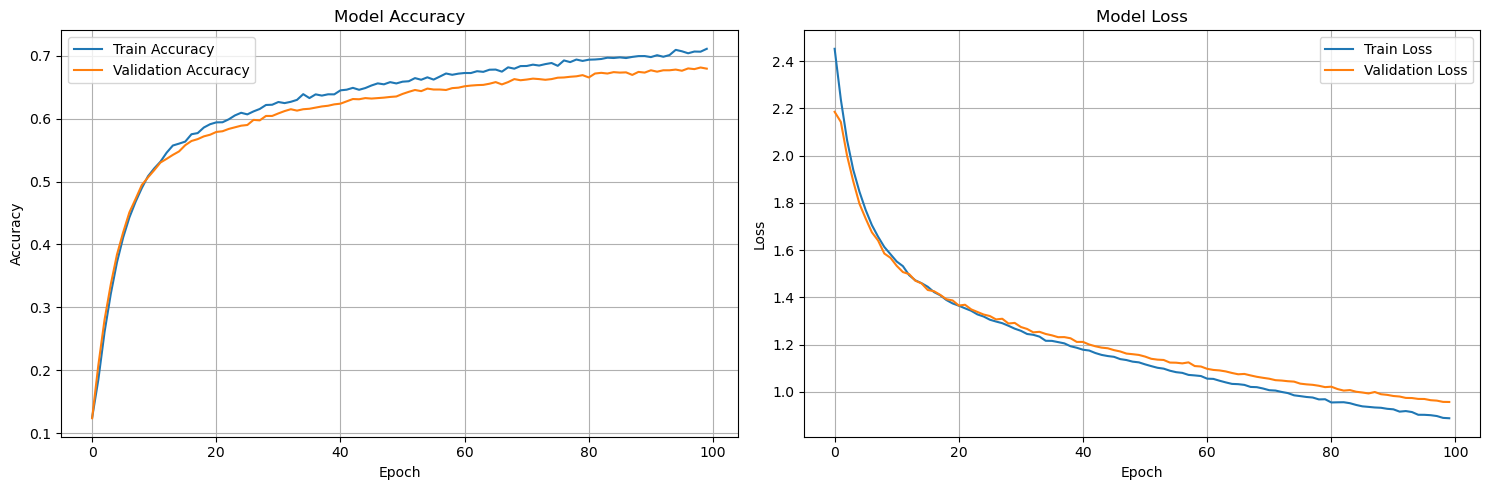

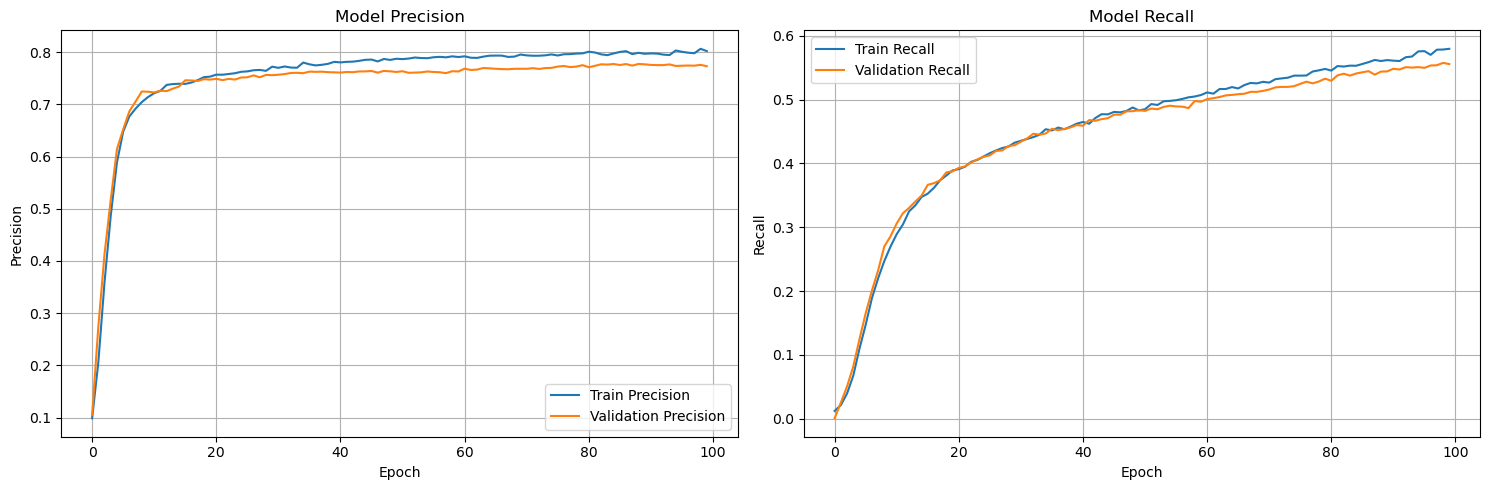

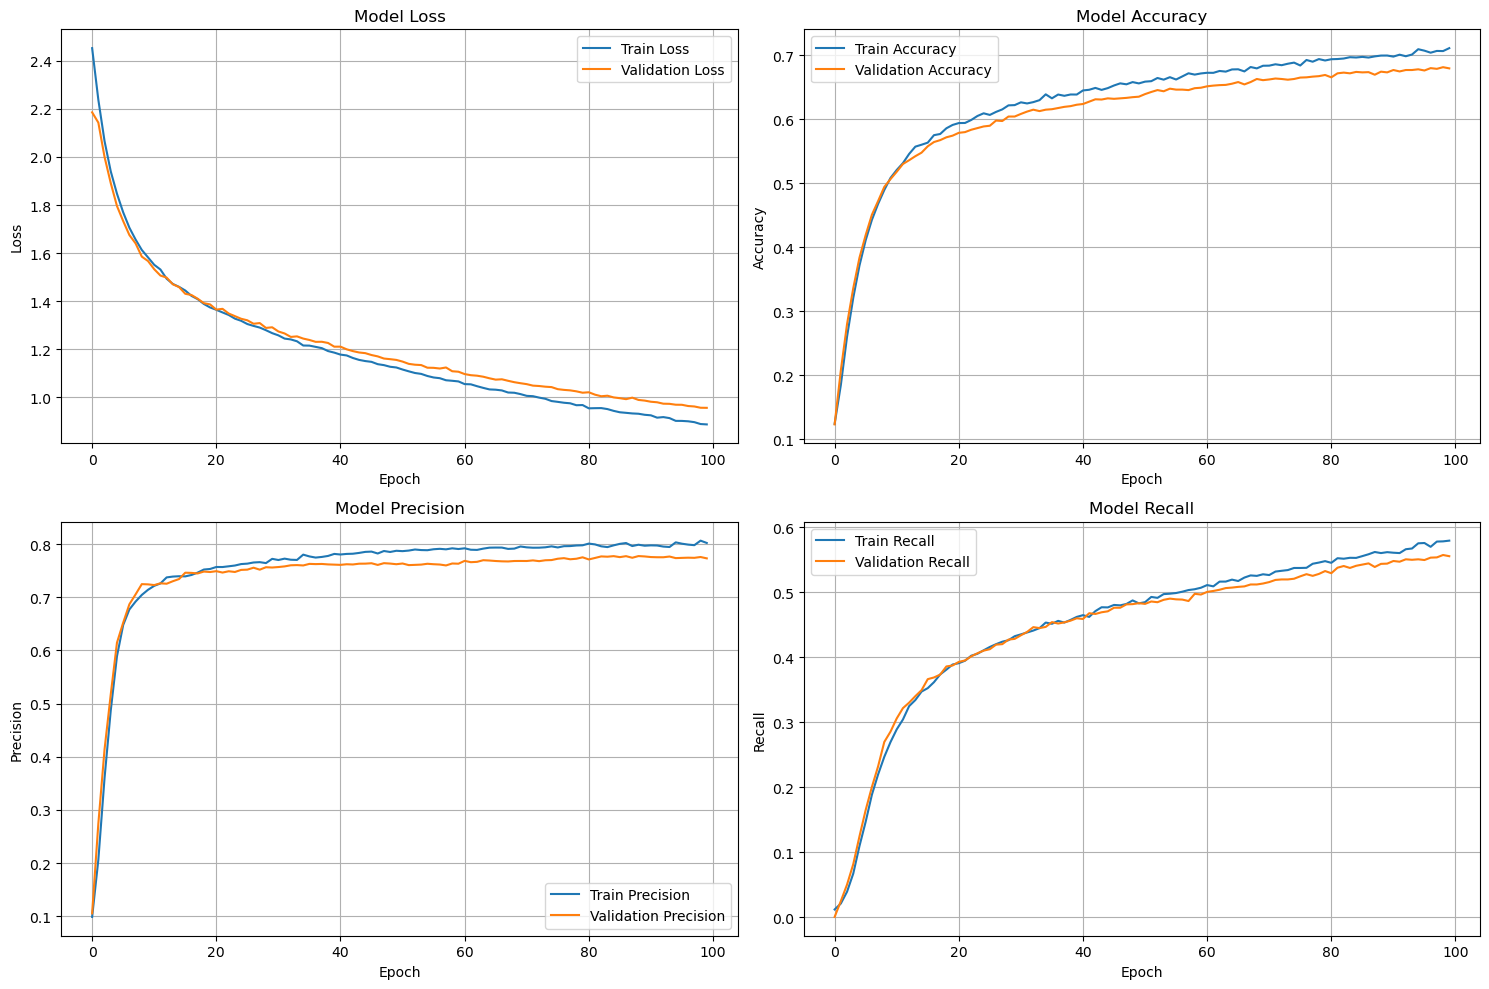

Evaluando en test set...

=== RESULTADOS FINALES MULTICLASE ===
Test Loss: 0.9363
Test Accuracy: 0.6930

Otras métricas:
Métrica 1: 0.7763
Métrica 2: 0.5732
Modelo y mapeo de clases guardados


In [15]:

# 1. Cargar y preparar datos MULTICLASE
print("Cargando datos multiclase...")
X, y, class_names, class_mapping = load_and_prepare_data()

print(f"Número de clases: {len(class_names)}")
print(f"Clases: {list(class_names)}")

# 2. Dividir datos
print("Dividiendo datos...")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

print(f"Train: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples") 
print(f"Test: {X_test.shape[0]} samples")

# 3. Crear modelo MULTICLASE
print("Creando modelo VGG16 para clasificación multiclase...")
model = create_vgg16_model(num_classes=len(class_names))

# Mostrar resumen
model.summary()

# 4. Configurar entrenamiento MULTICLASE
callbacks = setup_training(model)

# 5. Entrenar modelo
print("Iniciando entrenamiento multiclase...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# 6. Graficar curvas de aprendizaje
print("\nGraficando curvas de aprendizaje...")
plot_learning_curves(history)
plot_detailed_learning_curves(history)

# 7. Evaluar en test
print("Evaluando en test set...")
test_results = model.evaluate(X_test, y_test, verbose=0)
test_loss, test_accuracy = test_results[0], test_results[1]

print("\n=== RESULTADOS FINALES MULTICLASE ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

if len(test_results) > 2:
    print("\nOtras métricas:")
    for i in range(2, len(test_results)):
        print(f"Métrica {i-1}: {test_results[i]:.4f}")

# Evaluación detallada multiclase
# evaluate_model(model, X_test, y_test, class_names)
    
# Ejecutar entrenamiento multiclase
# model, history, results, class_names = main_multiclass()

# Guardar el modelo y el mapeo de clases
model.save('vgg16_multiclass.keras')
np.save('class_names.npy', class_names)
print("Modelo y mapeo de clases guardados")